This notebook builds classifiers to distinguish aspirators from non-aspirators using different microbial communities (including combinations).

In [64]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from scipy.stats import fisher_exact

from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [65]:
import os, sys
src_dir = os.path.normpath(os.path.join(os.getcwd(), '../util'))
sys.path.append(src_dir)
import util

In [66]:
fotu = '../../data/clean/rosen.otu_table.rel_abun.clean'
fmeta = '../../data/clean/rosen.metadata.clean'

df = pd.read_csv(fotu, sep='\t', index_col=0)
meta = pd.read_csv(fmeta, sep='\t', index_col=0)

In [67]:
mbs_col = 'mbs_consolidated'

# Check that each aspiration patient has only one sample per site
meta.dropna(subset=[mbs_col]).groupby(['subject_id', 'site']).size().max()

1

In [68]:
meta = meta.dropna(subset=[mbs_col])
tidydf = util.tidyfy_otu(df, meta, mbs_col, cols=['ppi_consolidated'])
tidydf['ppi_consolidated'] = tidydf['ppi_consolidated'].fillna('nan')
tidydf.head()

Tidying data... 
Finished.


,sample,otu,abun,mbs_consolidated,site,subject_id,ppi_consolidated,otu_w_site
35,02-096-6G,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0.0,Normal,gastric_fluid,02-096-6,off,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...
621,02-096-6G,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.0,Normal,gastric_fluid,02-096-6,off,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
1207,02-096-6G,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.0,Normal,gastric_fluid,02-096-6,off,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
1793,02-096-6G,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.0,Normal,gastric_fluid,02-096-6,off,k__Bacteria;p__Actinobacteria;c__Actinobacteri...
2379,02-096-6G,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,0.0,Normal,gastric_fluid,02-096-6,off,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...


In [69]:
# Define some global variables
random_state = 12345
nml = 'Normal'
asp = 'Aspiration/Penetration'
aspdict = {'Normal': 0, 'Aspiration/Penetration': 1}
sites = util.get_sites()
sites

['bal', 'gastric_fluid', 'throat_swab']

# Single-site classifiers

These classifiers are trained using only one community per patient.

In [70]:
def single_site_classifier(s):
    """
    Make classifier based on site s.

    Global variables used are: meta, df (OTU table), aspdict, and random_state.
    """
    h_smpls = meta\
        .query('mbs_consolidated == @nml')\
        .query('site == @s')\
        .index.tolist()
    asp_smpls = meta\
        .query('mbs_consolidated == @asp')\
        .query('site == @s')\
        .index.tolist()

    X = df.loc[h_smpls + asp_smpls, :]
    Y = [aspdict[meta.loc[i, 'mbs_consolidated']] for i in X.index]
    X = X.values

    rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)

    results = util.cv_and_roc(rf, X, Y, random_state=random_state)

    # Print results
    print('N non-asp = {}, N asp = {}'.format(len(h_smpls), len(asp_smpls)))
    print('AUC = {}'.format(np.mean(results['auc_list'])))
    util.plot_auc_from_list(results['tpr_list'], results['mean_fpr'])
    print('Fisher results : {}'.format(fisher_exact(results['conf_mat'])))
    display(results['conf_mat'])

N non-asp = 36, N asp = 33
AUC = 0.65612244898
Fisher results : (2.4175824175824174, 0.093454101727910133)


,pred 0,pred 1
true 0,22,14
true 1,13,20


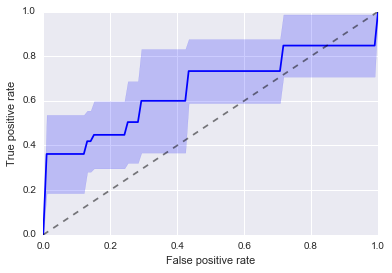

In [71]:
s = 'bal'
single_site_classifier(s)

N non-asp = 52, N asp = 42
AUC = 0.682171717172
Fisher results : (3.3333333333333335, 0.0090536020308857063)


,pred 0,pred 1
true 0,40,12
true 1,21,21


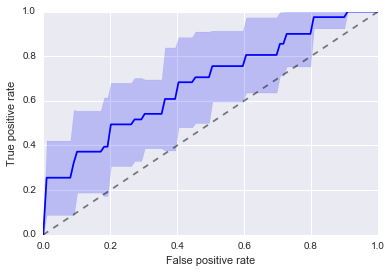

In [72]:
s = 'gastric_fluid'
single_site_classifier(s)

N non-asp = 46, N asp = 38
AUC = 0.669761904762
Fisher results : (2.1000000000000001, 0.15048048030485922)


,pred 0,pred 1
true 0,36,10
true 1,24,14


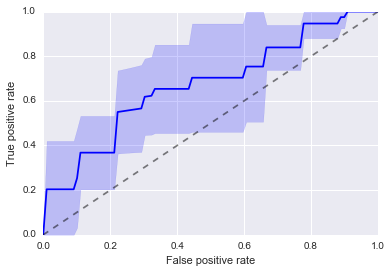

In [73]:
s = 'throat_swab'
single_site_classifier(s)

# Two-site classifiers

These classifiers are trained using two sites per patient.

In [74]:
def make_combined_site_df(tidydf, sites, mbs_col):
    """
    Return a wide-form dataframe with data from all sites.
    
    Drops any rows with NaNs (i.e. subjects which are missing
    one of the sites). Also drops any subjects without mbs_col
    metadata.
    
    Parameters
    ----------
    tidydf : pandas DataFrame
        'subject_id', 'site', and 'otu_w_site' columns
    sites : list
        list of sites to keep
    """
        
    tmpotu = tidydf.query('site == @sites')\
            .dropna(subset=[mbs_col])\
            .pivot(index='subject_id', columns='otu_w_site',
                   values='abun')\
            .dropna(axis=0)

    return tmpotu

def multi_site_classifier(tidydf, sites):
    """
    Make a multi-site classifiers.
    
    First makes a datafarme with has subject IDs in rows
    and OTUs in columns. OTUs are labeled by which site
    they were in (e.g. k__Bacteria;...;d__denovo123-bal and 
    k__Bacteria;...;d__denovo123-gastric_fluid are separate columns).
    
    tidydf has columns 'subject_id' and 'mbs_consolidated'
    
    sites is a list of sites to consider
    
    Global variables used: meta (with column 'subject_id'), aspdict, random_state, mbs_col
    """
    
    df = make_combined_site_df(tidydf, sites, mbs_col)
    
    subjects = df.index.tolist()
    
    # Using pandas.query matches order given in subjects, which matches
    # order in df (which becomes X)
    mbs_info = tidydf\
        .query('subject_id == @subjects')\
        [['subject_id', 'mbs_consolidated']]\
        .drop_duplicates()
        
    Y = [aspdict[i] for i in mbs_info['mbs_consolidated']]
    X = df.values
    
    
    rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)

    results = util.cv_and_roc(rf, X, Y, random_state=random_state)

    # Print results
    print(mbs_info.groupby('mbs_consolidated').size())
    print('AUC = {}'.format(np.mean(results['auc_list'])))
    util.plot_auc_from_list(results['tpr_list'], results['mean_fpr'])
    print('Fisher results : {}'.format(fisher_exact(results['conf_mat'])))
    display(results['conf_mat'])

bal, throat_swab
mbs_consolidated
Aspiration/Penetration    25
Normal                    24
dtype: int64
AUC = 0.816
Fisher results : (5.2777777777777777, 0.0095950485875508917)


,pred 0,pred 1
true 0,15,9
true 1,6,19


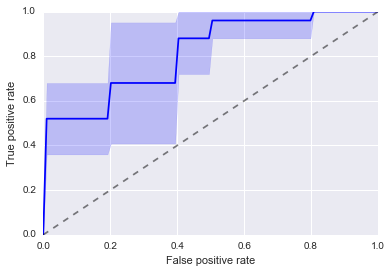

In [75]:
twosites = ['bal', 'throat_swab']
print(', '.join(twosites))
multi_site_classifier(tidydf, twosites)

bal, gastric_fluid
mbs_consolidated
Aspiration/Penetration    29
Normal                    30
dtype: int64
AUC = 0.697222222222
Fisher results : (3.7999999999999998, 0.01938318826179003)


,pred 0,pred 1
true 0,20,10
true 1,10,19


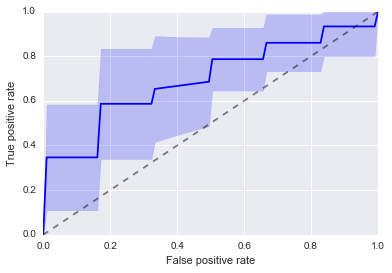

In [76]:
twosites = ['bal', 'gastric_fluid']
print(', '.join(twosites))
multi_site_classifier(tidydf, twosites)

throat_swab, gastric_fluid
mbs_consolidated
Aspiration/Penetration    33
Normal                    36
dtype: int64
AUC = 0.752465986395
Fisher results : (5.384615384615385, 0.0015215310681511674)


,pred 0,pred 1
true 0,28,8
true 1,13,20


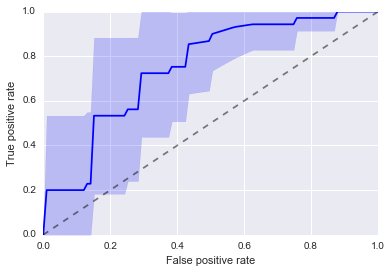

In [77]:
twosites = ['throat_swab', 'gastric_fluid']
print(', '.join(twosites))
multi_site_classifier(tidydf, twosites)

# All three sites

bal, gastric_fluid, throat_swab
mbs_consolidated
Aspiration/Penetration    23
Normal                    19
dtype: int64
AUC = 0.763333333333
Fisher results : (7.9333333333333336, 0.0046071082941318217)


,pred 0,pred 1
true 0,14,5
true 1,6,17


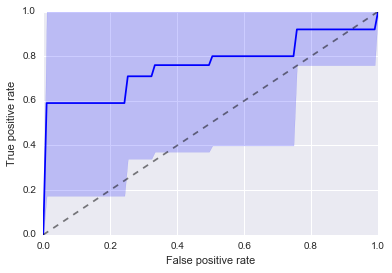

In [78]:
print(', '.join(sites))
multi_site_classifier(tidydf, sites)

# Check PPI confounding

For patients used in each classifier, show the confusion matrix of on/off PPI and yes/no aspiration.

## Single-site classifiers

In [79]:
from IPython.display import display
from scipy.stats import fisher_exact

def get_single_site_samples(s):
    h_smpls = meta\
        .query('mbs_consolidated == @nml')\
        .query('site == @s')\
        .index.tolist()
    asp_smpls = meta\
        .query('mbs_consolidated == @asp')\
        .query('site == @s')\
        .index.tolist()
    return h_smpls + asp_smpls

nml = 'Normal'
asp = 'Aspiration/Penetration'

In [80]:
def investigate_single_site(s):
    smpls = get_single_site_samples(s)
    print(s)
    confmat = pd.crosstab(
        meta.loc[smpls, 'mbs_consolidated'], 
        meta.loc[smpls, 'ppi_consolidated'])
    display(confmat)

    print(fisher_exact(confmat.drop('conflicting', axis=1)))

In [81]:
investigate_single_site('bal')

bal


ppi_consolidated,conflicting,off,on
mbs_consolidated,,,
Aspiration/Penetration,1,16,16
Normal,2,11,23


(2.0909090909090908, 0.2105954920138336)


In [82]:
investigate_single_site('gastric_fluid')

gastric_fluid


ppi_consolidated,conflicting,off,on
mbs_consolidated,,,
Aspiration/Penetration,1,19,22
Normal,1,22,29


(1.1384297520661157, 0.83407484281092659)


In [83]:
investigate_single_site('throat_swab')

throat_swab


ppi_consolidated,conflicting,off,on
mbs_consolidated,,,
Aspiration/Penetration,2,14,22
Normal,1,22,23


(0.66528925619834711, 0.49998486800531511)


## Two sites

In [84]:
mbs_col = 'mbs_consolidated'

def get_multi_site_subjects(sites):
    df = make_combined_site_df(tidydf, sites, mbs_col)    
    subjects = df.index.tolist()
    
    return subjects

def investigate_multi_site_subjects(sites):
    print(sites)
    
    subjects = get_multi_site_subjects(sites)
    
    meta_info = tidydf\
        .query('subject_id == @subjects')\
        [['subject_id', 'mbs_consolidated', 'ppi_consolidated']]\
        .drop_duplicates()
    
    confmat = pd.crosstab(
        meta_info['mbs_consolidated'], 
        meta_info['ppi_consolidated'])
    
    display(confmat)
    
    print(fisher_exact(confmat.drop('conflicting', axis=1)))

In [85]:
twosites = ['bal', 'throat_swab']
investigate_multi_site_subjects(twosites)

['bal', 'throat_swab']


ppi_consolidated,conflicting,off,on
mbs_consolidated,,,
Aspiration/Penetration,1,9,15
Normal,1,9,14


(0.93333333333333335, 1.0)


In [86]:
twosites = ['bal', 'gastric_fluid']
investigate_multi_site_subjects(twosites)

['bal', 'gastric_fluid']


ppi_consolidated,conflicting,off,on
mbs_consolidated,,,
Aspiration/Penetration,1,14,14
Normal,1,10,19


(1.8999999999999999, 0.2888774436037147)


In [87]:
twosites = ['throat_swab', 'gastric_fluid']
investigate_multi_site_subjects(twosites)

['throat_swab', 'gastric_fluid']


ppi_consolidated,conflicting,off,on
mbs_consolidated,,,
Aspiration/Penetration,2,12,20
Normal,0,19,17


(0.5368421052631579, 0.2317635130885069)


In [88]:
allsites = ['bal', 'throat_swab', 'gastric_fluid']
investigate_multi_site_subjects(allsites)

['bal', 'throat_swab', 'gastric_fluid']


ppi_consolidated,conflicting,off,on
mbs_consolidated,,,
Aspiration/Penetration,1,8,14
Normal,0,8,11


(0.7857142857142857, 0.75684303636771089)
